Bayesian Statistics Made Simple
===

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2016 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
from scipy.special import gamma

from thinkbayes2 import Pmf, Suite
import thinkplot

In [2]:
# Picky plots for picky people
import seaborn as sns

Working with Pmfs
---
Create a Pmf object to represent a six-sided die.

In [3]:
d6 = Pmf()

A Pmf is a map from possible outcomes to their probabilities.

In [4]:
for x in [1,2,3,4,5,6]:
    d6[x] = 1

Initially the probabilities don't add up to 1.

In [5]:
d6.Print()

1 1
2 1
3 1
4 1
5 1
6 1


`Normalize` adds up the probabilities and divides through.  The return value is the total probability before normalizing.

In [6]:
d6.Normalize()

6

Now the Pmf is normalized.

In [7]:
d6.Print()

1 0.16666666666666666
2 0.16666666666666666
3 0.16666666666666666
4 0.16666666666666666
5 0.16666666666666666
6 0.16666666666666666


And we can compute its mean (which only works if it's normalized).

In [8]:
d6.Mean()

3.5

`Random` chooses a random value from the Pmf.

In [9]:
d6.Random()

6

`thinkplot` provides methods for plotting Pmfs in a few different styles.

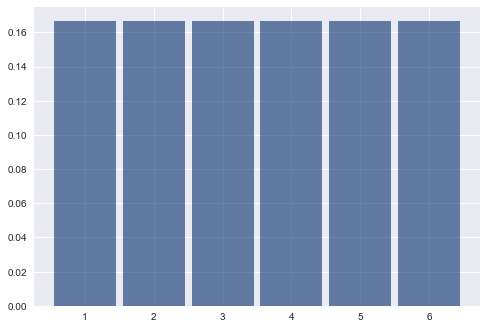

In [10]:
thinkplot.Hist(d6)

**Exercise 1:**  The Pmf object provides `__add__`, so you can use the `+` operator to compute the Pmf of the sum of two dice.

Compute and plot the Pmf of the sum of two 6-sided dice.

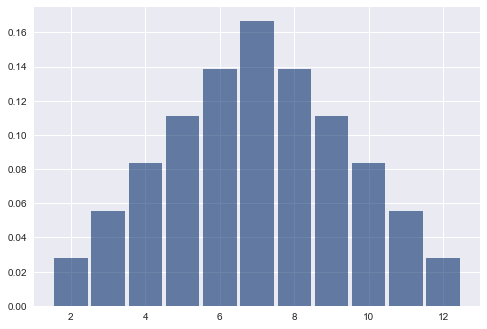

In [11]:
thinkplot.Hist(d6 + d6)

**Exercise 2:** Suppose I roll two dice and tell you the result is greater than 3.

Plot the Pmf of the remaining possible outcomes and compute its mean.

7.393939393939394


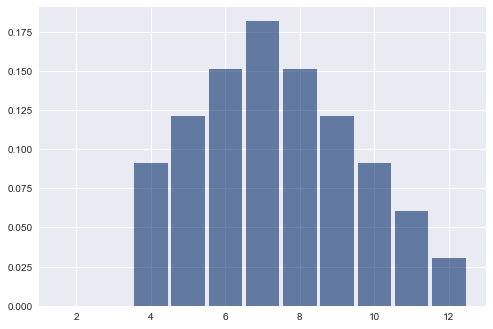

In [12]:
d6_2 = d6 + d6
d6_2[2], d6_2[3] = 0, 0
d6_2.Normalize()
thinkplot.Hist(d6_2)
print(d6_2.Mean())

The cookie problem
---
    Suppose there are two cookie bowls.

    Bowl #1 contains 10 vanilla and 30 chocolate cookies.
    Bowl #2 contains 20 each.
    You can't see the bowl label.
    
    You pick a vanilla cookie.
    What is the probability that you picked from bowl #1?

Create a Pmf with two equally likely hypotheses.


In [13]:
cookie = Pmf(['Bowl 1', 'Bowl 2'])
cookie.Print()

Bowl 1 0.5
Bowl 2 0.5


Update each hypothesis with the likelihood of the data (a vanilla cookie from Bowl 1).

In [14]:
# Vanilla cookies make 75% of all cookies of the uneven bowl
cookie['Bowl 1'] *= 0.75
cookie['Bowl 2'] *= 0.5
cookie.Normalize()

0.625

Print the posterior probabilities.

In [15]:
cookie.Print()

Bowl 1 0.6000000000000001
Bowl 2 0.4


**Exercise 3:** Suppose we put the first cookie back, stir, choose again from the same bowl, and get a chocolate cookie.

Hint: The posterior (after the first cookie) becomes the prior (before the second cookie).

Pmf({'Bowl 1': 0.4285714285714286, 'Bowl 2': 0.5714285714285714})


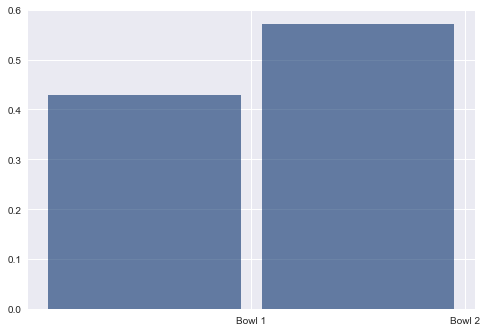

In [16]:
# Chocolate cookies make up 25% of the uneven bowl, 50% in the other
cookie['Bowl 1'] *= 0.25
cookie['Bowl 2'] *= 0.5
cookie.Normalize()
thinkplot.Hist(cookie)
print(cookie)

**Exercise 4:** Instead of doing two updates, what if we collapse the two pieces of data into one update?

Re-initialize `Pmf` with two equally likely hypotheses and perform one update based on two pieces of data, a vanilla cookie and a chocolate cookie.

The result should be the same regardless of how many updates you do (or the order of updates).

Bowl 1 0.42857142857142855
Bowl 2 0.5714285714285714


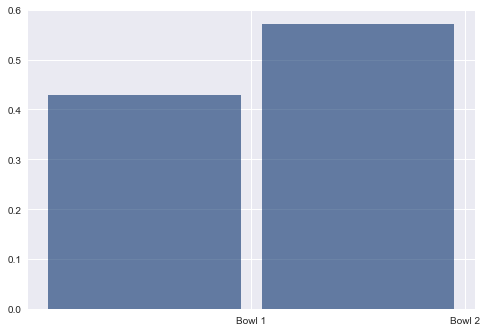

In [17]:
cookie['Bowl 1'] = 0.5
cookie['Bowl 2'] = 0.5

# Order is different
cookie['Bowl 1'] *= 0.25
cookie['Bowl 2'] *= 0.5
cookie['Bowl 1'] *= 0.75
cookie['Bowl 2'] *= 0.5
cookie.Normalize()
cookie.Print()
thinkplot.Hist(cookie)

The dice problem
---
Create a Suite to represent dice with different numbers of sides.

In [18]:
suite = Suite([4, 6, 8, 12])
suite.Print()

4 0.25
6 0.25
8 0.25
12 0.25


**Exercise 5:** We'll solve this problem two ways.  First we'll do it "by hand", as we did with the cookie problem; that is, we'll multiply each hypothesis by the likelihood of the data, and the renormalize.

In the space below, update `suite` based on the likelihood of the data (rolling a 6), then normalize and print the results.

In [19]:
suite = Suite([4, 6, 8, 12])

suite[4] *= 0
suite[6] *= 1 / 6
suite[8] *= 1 / 8
suite[12] *= 1 / 12

suite.Normalize()
suite.Print()

4 0.0
6 0.4444444444444445
8 0.33333333333333337
12 0.22222222222222224


**Exercise 6:**  Now let's do the same calculation using `Suite.Update`.

Write a definition for a new class called `Dice` that extends `Suite`.  Then define a method called `Likelihood` that takes `data` and `hypo` and returns the probability of the data (the outcome of rolling the die) for a given hypothesis (number of sides on the die).

Hint: What should you do if the outcome exceeds the hypothetical number of sides on the die?

Here's an outline to get you started:

In [20]:
class Dice(Suite):
        # hypo is the number of sides on the die
        # data is the outcome
        def Likelihood(self, data, hypo):
            if data > hypo:
                return 0
            else:
                return 1 / hypo

Now we can create a `Dice` object and update it.

In [21]:
dice = Dice([4, 6, 8, 12])
dice.Update(6)
dice.Print()

4 0.0
6 0.4444444444444445
8 0.33333333333333337
12 0.22222222222222224


If we get more data, we can perform more updates.

In [22]:
for roll in [8, 7, 7, 5, 4]:
    dice.Update(roll)

Here are the results.

In [23]:
dice.Print()

4 0.0
6 0.0
8 0.9192938209331653
12 0.08070617906683476


In [24]:
# But if a pure certainty arises, we get a definite answer.
dice.Update(9)
dice.Print()

4 0.0
6 0.0
8 0.0
12 1.0


The German tank problem
---
The German tank problem is actually identical to the dice problem.

In [25]:
class Tank(Suite):
    # hypo is the number of tanks
    # data is an observed serial number
    def Likelihood(self, data, hypo):
        if data > hypo:
            return 0
        else:
            return 1 / hypo

Here are the posterior probabilities after seeing Tank #37.

If you had to place a bet on the exact number of tanks
produced that month, you would simply state
Max Likelihood: 37

But remember that it's the area under the curve of the pmf that matters
Mean: 		62.822944785168964


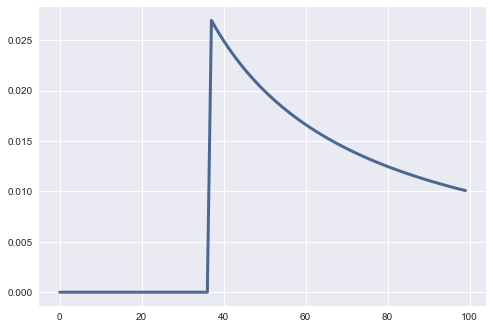

In [26]:
tank = Tank(range(100))
tank.Update(37)
thinkplot.Pdf(tank)

print("""If you had to place a bet on the exact number of tanks
produced that month, you would simply state""")
print(f'Max Likelihood: {tank.MaximumLikelihood()}')
print("""\nBut remember that it's the area under the curve of the pmf that matters""")
print(f'Mean: \t\t{tank.Mean()}')

**Exercise 7:**  Suppose we see another tank with serial number 17.  What effect does this have on the posterior probabilities?

Update the suite again with the new data and plot the results.

Max Likelihood: 37
Mean: 		57.81472076260485


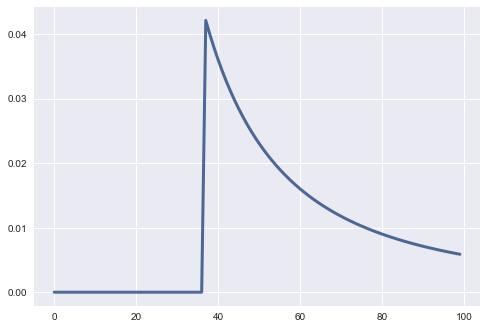

In [27]:
# Solution goes here
tank.Update(17)
thinkplot.Pdf(tank)
print(f'Max Likelihood: {tank.MaximumLikelihood()}')
print(f'Mean: \t\t{tank.Mean()}')

The Euro problem
---

**Exercise 8:**  Write a class definition for `Euro`, which extends `Suite` and defines a likelihood function that computes the probability of the data (heads or tails) for a given value of `x` (the probability of heads).

Note that `hypo` is in the range 0 to 100.  Here's an outline to get you started.

In [28]:
class Euro(Suite):
    
    def Likelihood(self, data, hypo):
        """ 
        hypo is the prob of heads (0-100)
        data is a string, either 'H' or 'T'
        """
        if data == 'H':
            return hypo / 100
        else:
            return 1 - (hypo / 100)

We'll start with a uniform distribution from 0 to 100.

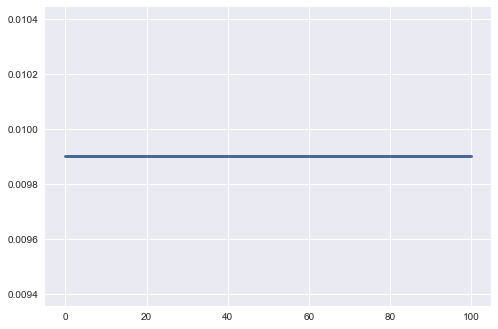

In [29]:
euro = Euro(range(101))
thinkplot.Pdf(euro)

Now we can update with a single heads:

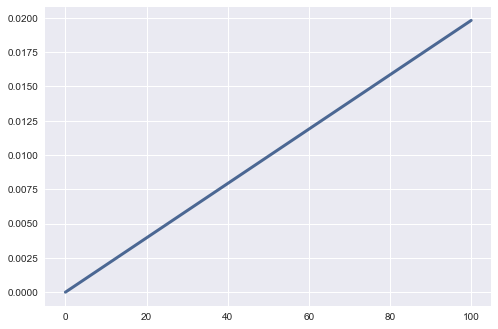

In [30]:
euro.Update('H')
thinkplot.Pdf(euro)

Another heads:

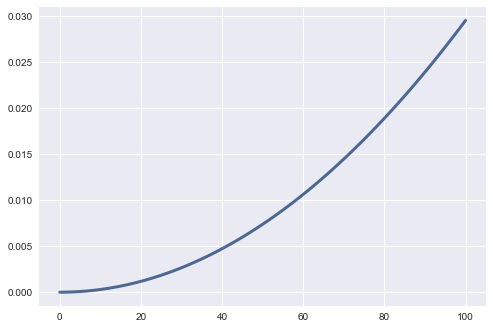

In [31]:
euro.Update('H')
thinkplot.Pdf(euro)

And a tails:

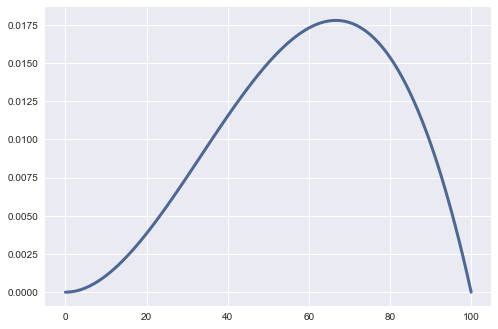

In [32]:
euro.Update('T')
thinkplot.Pdf(euro)

Starting over, here's what it looks like after 7 heads and 3 tails.

70

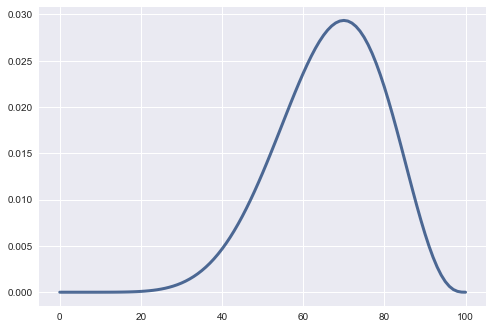

In [33]:
euro = Euro(range(101))

for outcome in 'HHHHHHHTTT':
    euro.Update(outcome)

thinkplot.Pdf(euro)
euro.MaximumLikelihood()

The maximum posterior probability is 70%, which is the observed proportion.

Here are the posterior probabilities after 140 heads and 110 tails.

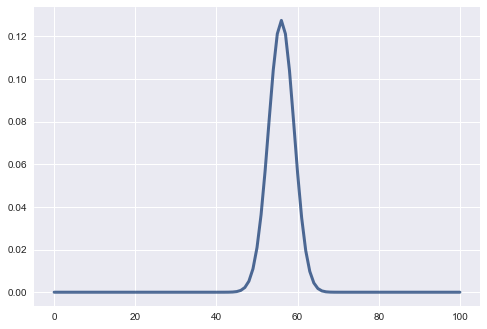

In [34]:
euro = Euro(range(101))

evidence = 'H' * 140 + 'T' * 110
for outcome in evidence:
    euro.Update(outcome)
    
thinkplot.Pdf(euro)

The posterior mean s about 56%

In [35]:
euro.Mean()

55.952380952380956

So is the value with maximum posterior probability.

In [36]:
euro.MaximumLikelihood()

56

The posterior credible interval has a 90% chance of containing the true value (provided that the prior distribution truly represents our background knowledge).

In [37]:
euro.CredibleInterval(95)

(50, 62)

## Swamping the prior

The following function makes a Euro object with a triangle prior.

In [38]:
def TrianglePrior():
    """Makes a Suite with a triangular prior."""
    suite = Euro(label='triangle')
    for x in range(0, 51):
        suite[x] = x
    for x in range(51, 101):
        suite[x] = 100-x 
    suite.Normalize()
    return suite

And here's what it looks like:

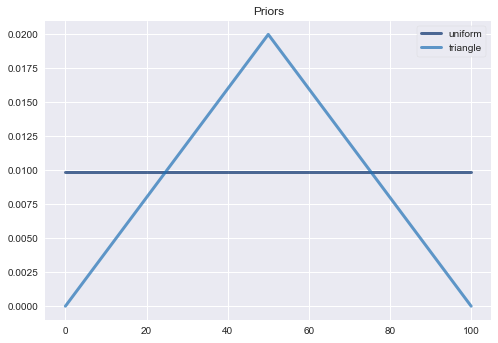

In [39]:
euro1 = Euro(range(101), label='uniform')
euro2 = TrianglePrior()
thinkplot.Pdfs([euro1, euro2])
thinkplot.Config(title='Priors')

**Exercise:** Update euro1 and euro2 with the same data we used before (140 heads and 110 tails) and plot the posteriors.  How big is the difference in the means?

55.74349943859506
56
(50, 62)
Difference between the means when using the two different priors is 0.209


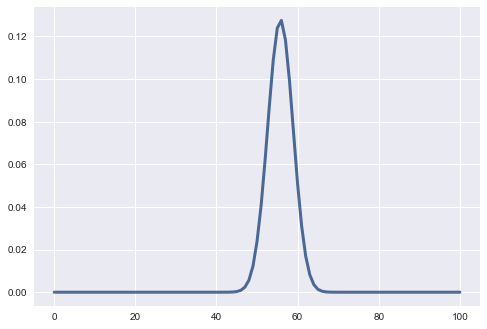

In [42]:
euro2 = TrianglePrior()
for outcome in evidence:
    euro2.Update(outcome)
    
thinkplot.Pdf(euro2)

print(euro2.Mean())
print(euro2.MaximumLikelihood())
print(euro2.CredibleInterval(95))

diff = round(abs(euro.Mean() - euro2.Mean()), 3)
print(f'Difference between the means when using the two different priors is {diff}')